In [1]:
import os
from collections import Counter
import re
from nltk import sent_tokenize, word_tokenize
from tdmh import *
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances , euclidean_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

## Collect all the titles

Firstly, we collect all the titles of the files in the corpus. The texts in the corpus are saved in a list named `corpus`. 

In [2]:
dir = 'Corpus'
corpus = []

for file in os.listdir(dir):
    if not(re.search(r'^\.' , file)): 
        path = os.path.join(dir,file)
        corpus.append(path)

## Collect data about the texts 

Next, we collect data about the number of tokens, the number of sentences, the type-token ratio, the sentiment score and the frequencies of specific POS categories. We collect these data for each text in the corpus. 

The code also adds values for categorical variables, copied from a file named `metadata.csv`. For more information, see the notebook named `Metadata.ipynb`. The categorical variables that need to be added must be specified in the list named `categorical_variables` below.

In [3]:
metadata = pd.read_csv('metadata.csv')
metadata = metadata.set_index('title')
categorical_variables = ['Class']

In [4]:
def extract_title(path):
    title = os.path.basename(path)
    title = re.sub( r'[.]txt$' , '' , title )
    return title

This notebook can collect data both for text in English and and for text in Dutch. If the texts in the corpus are in Dutch, the value of the variable `language` needs to be changed in the cell below.   

In [5]:
ttr_cap = 3000

language = 'eng'
#language = 'dut'


if language == 'eng':
    from nltk import pos_tag
elif language == 'dut':
    import nltk
    nltk.download('alpino')
    from nltk.corpus import alpino as alp
    from nltk.tag import UnigramTagger, BigramTagger
    training_corpus = alp.tagged_sents()
    unitagger = UnigramTagger(training_corpus)
    bitagger = BigramTagger(training_corpus, backoff=unitagger)
    pos_tag = bitagger.tag

In [6]:
out = open( 'data.csv' , 'w' , encoding = 'utf-8' )

## Sentiment Analysis
ana = SentimentIntensityAnalyzer()

if language == 'eng':
    pos_tags = ['JJ','JJR','JJS','VBD','MD','RB','RBR','RBS']
elif language == 'dut':
    pos_tags = ['verb','adv','adj','comp','noun', 'prep']
    

## Header of the CSV file
out.write('title,tokens,sentences,ttr,sentiment')

for t in pos_tags:
    out.write(f',{t}')

for c in categorical_variables:
    out.write(f',{c}')

out.write('\n')

for text in corpus:
    
    # The dictionary named 'data' saves the data about the text
    data = dict()
    print( f'Analysing {text} ...')
    
    ## Get the title, based on the filename
    title = extract_title( text )
    
    ## read the full text
    fh = open( text, encoding = 'utf-8')
    full_text = fh.read()
    
    ## count the number of sentences
    sentences = sent_tokenize(full_text)
    data['nr_sentences'] = len(sentences)
    
    # dictionary to count the POS tags
    freq_pos = dict()    
    
    # variables for the calculation of type-token ratio
    
    freq_ttr = dict()
 
    # token count is initalised at 0
    data['nr_tokens'] = 0
    
    # list for the sentiment scores
    all_scores = []

        
    for s in sentences:
        words = word_tokenize(s)
        words = remove_punctuation(words)
        
        tags = pos_tag(words)
        
        scores = ana.polarity_scores(s)
        all_scores.append( scores["compound"] )
        
        # Each tag consists of two values: 
        # [0]: the word and [1] the POS tag
        for word_tag in tags:
            word = word_tag[0]
            tag = word_tag[1]
            
            # count the tokens
            data['nr_tokens'] += 1
            
            # place tokens in dictionary freq_ttr
            # only if the word count is less than ttr_cap
            # The nr of items in the dictionary eventually equals the nr of types
            if data['nr_tokens'] <= ttr_cap:
                freq_ttr[ word ] = freq_ttr.get( word , 0 ) + 1
                
            ## Count frequencies of all the POS tags
            freq_pos[ tag ] = freq_pos.get( tag ,0) +1
            
    for t in pos_tags:
        data[t] = freq_pos.get(t,0)
    data['sentiment'] = sum(all_scores) / len(all_scores)

                
    # Calculate TTR: number of items in freq_ttr dictyionary
    # divided by ttr_cap
    data['ttr'] = len( freq_ttr ) / ttr_cap
    
    # write the results to a CSV file    
    out.write( f"{title},{data['nr_tokens']},{data['nr_sentences']},{data['ttr']},{data['sentiment']}" )
    for t in pos_tags:
        out.write( f",{data[t] }"  )
        
    for c in categorical_variables:
        out.write( f",{metadata.loc[title][c] }"  )
        
    out.write('\n')

    
out.close()
print('Done!')

Analysing Corpus/Ulysses.txt ...
Analysing Corpus/ThroughtheLookingGlass.txt ...
Analysing Corpus/HeartofDarkness.txt ...
Analysing Corpus/ARoomWithaView.txt ...
Analysing Corpus/ATaleofTwoCities.txt ...
Analysing Corpus/PrideandPrejudice.txt ...
Done!


## Read the data from the CSV

Once the CSV file containing all the data has been created, we can start the analyses. The data is firstly read using the `read_csv()` method from `pandas`. 

In [7]:
data = pd.read_csv('data.csv')

## Visualisations

In many of the visualisations below, the colours represent the different values for a categorical variable in the CSV file named 'metdata.csv'. 
In the cell below, specify the column containing the values that need to be visualised. 


In [8]:
categorical_variable = 'Class'

### Average sentence length

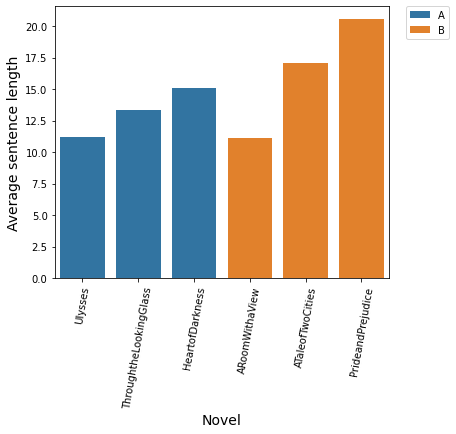

In [9]:
data = data.sort_values(by=categorical_variable)

x_axis = data['title']
y_axis = data['tokens'] / data['sentences']


hue = data[categorical_variable]

fig = plt.figure( figsize=( 6 , 5 ) )


graph = sns.barplot( x=x_axis, y=y_axis, hue=hue , dodge=False )

#graph.set_title('' , size = 20) 
graph.set_xlabel('Novel' , size = 14) 
graph.set_ylabel('Average sentence length' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);


plt.show()

### Type-token ratio

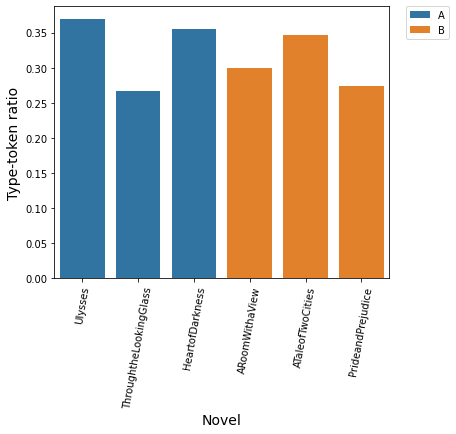

In [10]:
x_axis = data['title']
y_axis = data['ttr']
hue = data[categorical_variable]

data = data.sort_values(by= categorical_variable )

fig = plt.figure( figsize=( 6 , 5 ) )

#df_sorted = df.sort_values(by=[ y_axis] , ascending = False)

graph = sns.barplot( x=x_axis, y=y_axis, hue=hue , dodge=False )

#graph.set_title('' , size = 20) 
graph.set_xlabel('Novel' , size = 14) 
graph.set_ylabel('Type-token ratio' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);


plt.show()

### Modal verbs

Can you add code to do a comparative analysis of the use of modal verbs? The POS code for modal verbs is 'MD'

### Adjectives and Adverbs

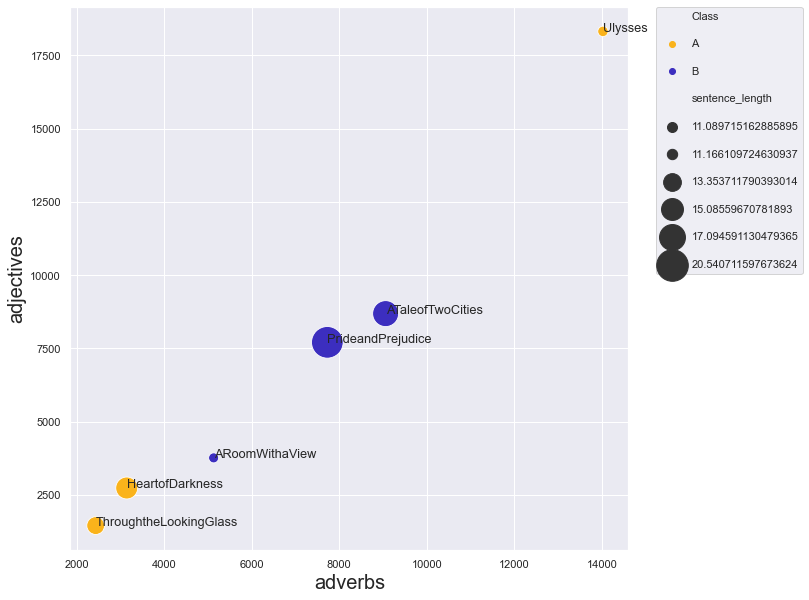

In [11]:
data['adjectives'] = data['JJ'] + data['JJS'] + data['JJS']
data['adverbs'] = data['RB'] + data['RBR'] + data['RBS'] 
data['adverbs'] = data['VBD'] 
data['sentence_length'] = data['tokens'] / data['sentences']

# Columns to use in the visualisation
y_axis = 'adjectives'
x_axis = 'adverbs'
point_size =  'sentence_length'
point_colour = categorical_variable

colours = [ '#fab31b' , '#3c2ebf'  ] 

fig = plt.figure( figsize = ( 10,10 ))

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=data , x=x_axis, y=y_axis,  
                     hue= point_colour, size= point_size, sizes=( 100 , 1000) , 
                      palette = colours  )

for index, row in data.iterrows():
    plt.text( row[x_axis], row[y_axis] , row['title'] , fontsize=12.8)


ax.set_xlabel( x_axis  , fontsize = 20 )
ax.set_ylabel( y_axis  , fontsize = 20 )
# ax.set_title( '' , fontsize=24 )


# # this next line places the legend outside of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# plt.savefig( 'scatterplot.png' , dpi=300 )

## Type-token ratio and average sentence length

Can you create a scatter plot which can be used to explore the values for the type-token ratio and average sentence length? Also provide suitable labels for the X-axis and the Y-axis

# Diction

To study the vocabulary, it can be useful to create a document-term matrix as a first step. 
In such a document-term matrix, the rows represent the documents in the collection and columns correspond to the types (i.e. the unique words that are found).  

In [12]:
all_frequencies = dict()
all_words = Counter()
all_lengths = dict()
titles = []

for book in corpus:
    print(book)
    row = []
    
    ## Extract the title from the filename
    title = extract_title(book)
    titles.append(title)
    
    ## Read the full text
    file = open(book,encoding='utf-8')
    full_text = file.read()
    
    ## Find all the words in the text
    words = tokenise_remove_stopwords(full_text.lower())
    all_lengths[title] = len(words)
    
    ## Count all the words in the text
    freq_book = Counter(words)
    all_frequencies[title] = freq_book

    ## Update the Counter object named 'all_words'
    all_words.update(words)
        
print('Done!')

vocabulary = list(all_words.keys())

dtm = pd.DataFrame( columns= all_words )
        
for book in titles:
    row = dict()
    freq = all_frequencies[book]
    for w in vocabulary:
        row[w] = freq.get(w,0)/all_lengths[book]
    dtm = dtm.append( row  , ignore_index=True )
    

dtm.index = titles

Corpus/Ulysses.txt
Corpus/ThroughtheLookingGlass.txt
Corpus/HeartofDarkness.txt
Corpus/ARoomWithaView.txt
Corpus/ATaleofTwoCities.txt
Corpus/PrideandPrejudice.txt
Done!


## Unique words

In [13]:
tdm = dtm.transpose()

def find_unique_words(tdm,book,nr_words=50):
    columns_other = list(tdm.columns)
    columns_other.remove(book)
    tdm['sum_other'] = tdm[columns_other].sum(axis=1) 
    tdm = tdm.query( 'sum_other == 0' )
    tdm = tdm.query( f'{book} > 0' )
    tdm = tdm.sort_values(book,ascending=False)[book][:nr_words]
    return list(tdm.keys())

for file in corpus:
    title = extract_title(file)
    unique = tdm.copy()
    unique_words = find_unique_words(unique,title,25)
    print(f'\n{title.upper()}\n')
    for word in unique_words:
        print(word)
    


ULYSSES

stephen
dedalus
mulligan
dublin
buck
lenehan
martin
zoe
dignam
henry
cunningham
ben
leopold
conmee
boylan
molly
lynch
ned
cissy
haines
gerty
alf
dollard
lambert
hes

THROUGHTHELOOKINGGLASS

tweedledum
tweedledee
hatta
haigha
dinah
frog
mome
toves
gyre
gimble
wabe
slithy
outgrabe
brillig
subtraction
mimsy
sulkily
chessmen
cinders
borogoves
fastness
jabberwock
dna
bandersnatch
memorandum

HEARTOFDARKNESS

kurtz
pilgrims
steamboat
rivets
marlow
snag
russian
stretcher
invasion
riverside
impenetrable
administration
immensity
pitiless
canoes
fossil
ripple
cipher
director
swede
nightmares
intrusted
glittered
rebels
partnership

AROOMWITHAVIEW

beebe
bartlett
honeychurch
emerson
lavish
vyse
emersons
alans
alan
pension
cissie
bertolini
croce
baedeker
arno
eleanor
tunbridge
signora
piazza
phaethon
constantinople
weald
pond
hullo
fiesole

ATALEOFTWOCITIES

defarge
pross
manette
carton
darnay
lucie
cruncher
stryver
monseigneur
tellson
marquis
antoine
evremonde
mender
barsad
republic
pris

## Distinctive words

In [14]:
distinctive = tdm.copy()
distinctive['average'] = distinctive.mean(numeric_only=True,axis=1)


for book in titles:
    column_name = f'{book}_distinction'
    values = []
    for word,freq in distinctive.iterrows():

        score = (freq[book] - freq['average'])
        if pd.isna(score):
            score = 0
        values.append(score)
    distinctive[column_name] = values
    
def most_distinctive_words(df,book): 
    column_name = f'{book}_distinction'
    return df[column_name].sort_values( ascending = False )[:30]

for title in titles:
    print(f'\n{title.upper()}\n')
    for word,count in most_distinctive_words(distinctive,title).items():
        print( f'{word} ({count}) ' )


ULYSSES

bloom (0.005841420574757523) 
mr (0.003872420785256443) 
stephen (0.0033510172983040325) 
says (0.002568186356178809) 
street (0.0013607762226651712) 
old (0.0012265562810075581) 
mrs (0.0011559373016019068) 
god (0.0011440288937234005) 
john (0.0010809367889516785) 
dedalus (0.0010053051894912098) 
mulligan (0.000946515412327981) 
hat (0.0008742755015319975) 
joe (0.0007890707278114551) 
lord (0.0007410502509843033) 
dublin (0.0007231142591077122) 
buck (0.0006819614150934523) 
irish (0.0006381208629079135) 
woman (0.0006372726777654648) 
lenehan (0.0006290506156465465) 
martin (0.0006231716379302236) 
yes (0.0006168133453879855) 
zoe (0.0006114136824975779) 
bloody (0.0006000849650063293) 
father (0.0005903229052177026) 
fellow (0.000531015909925385) 
sir (0.0005181383255220362) 
big (0.0004897837901193785) 
bit (0.00048217111461696315) 
ireland (0.0004775219788823303) 
dignam (0.00047619719502215195) 

THROUGHTHELOOKINGGLASS

alice (0.02905885549602264) 
said (0.0223723617

## Similarity

In [15]:
most_common = all_words.most_common(20000)
most_common_list = [word for word,count in most_common]
dtm_mc = dtm[ most_common_list ]

matrix = euclidean_distances(dtm_mc)
matrix_df = pd.DataFrame( matrix , columns = titles , index = titles )

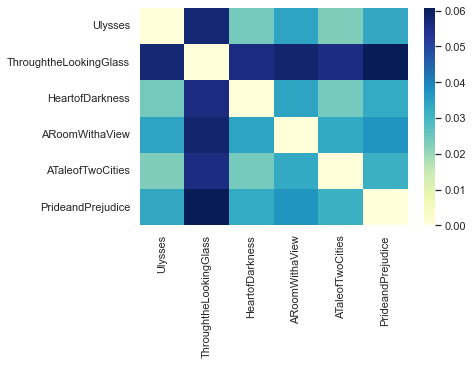

In [16]:
import seaborn as sns
# Heatmap
ax = sns.heatmap( matrix_df , cmap="YlGnBu"  )

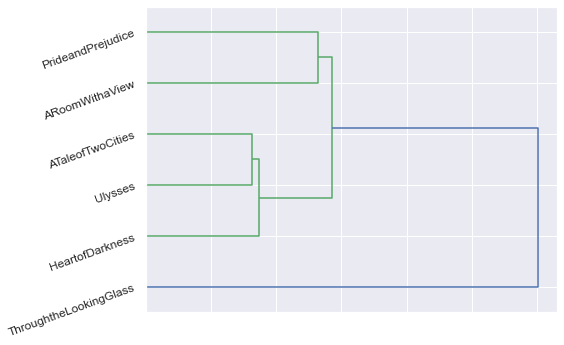

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram

from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)


linkages = linkage(matrix_df,'ward')

plt.figure(figsize=(8,5))
dendrogram( linkages , labels = matrix_df.index , orientation="right", leaf_font_size=12, leaf_rotation=20)
plt.tick_params(axis='x', which='both', bottom=False,
top=False, labelbottom=False)
plt.tight_layout()
plt.show()

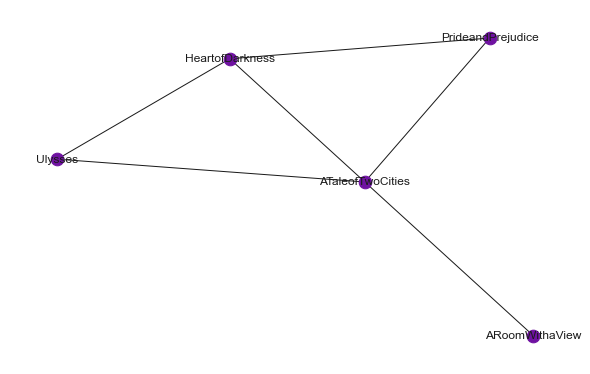

In [18]:
mean_dist = 0
for row in matrix_df.mean():
    mean_dist += row
    
mean_dist = mean_dist / len(matrix_df.mean())



from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

nodes = [] 
edges = []


related_texts = list(matrix_df.columns)

## an edge is drawn in between two nodes
# if the cosine similarity is 0.7 or higher
min_similarity = 0.7

for text,values in matrix_df.iterrows():
    for rt in related_texts:
        if text != rt:
            if values[rt] < mean_dist:
                edges.append( (text,rt) )
                nodes.append(text)

nodes = list( set(nodes) )

G = nx.Graph()

#pos = nx.gaussian_random_partition_graph(G)
pos = nx.fruchterman_reingold_layout(G,scale=1)
pos=nx.spring_layout(G,scale=0.5) 

G.add_nodes_from( nodes )
G.add_edges_from( edges )



plt.figure(figsize=(8,5))
nx.draw(G , node_size=160 , with_labels = True , node_color='#6f12a1')
                

# Lexicons

In [19]:
import re
import requests
import os

baseUrl = 'https://raw.githubusercontent.com/peterverhaar/semanic-tagging/main/Lexicons/'
lexicon_files = [  'Academic.txt' , 'Economics.txt' ,  'Legal.txt' , 'Military.txt' , 'Movement.txt' , 'Pain.txt' , 'Passive.txt' , 'Pleasure.txt' , 'Politics.txt' , 'Power.txt' , 'Religion.txt' , 'Space.txt' , 'Time.txt' , 'Transportation.txt' , 'Vice.txt' , 'Weather.txt' , 'workAndEmployment.txt' ]

dir = 'Lexicons'
if not os.path.isdir(dir):
    os.mkdir(dir)


for l in lexicon_files:
    topic = l[ : l.rindex('.') ]
    response = requests.get( baseUrl + l)
    words = []
    if response:
        response.encoding = 'utf-8'
        out = open( os.path.join( dir , l ) , 'w' , encoding = 'utf-8' )
        out.write( response.text )
        out.close()

print('Lexicons have been downloaded!')


import os 
from os.path import join
import re

lexicons = dict()

dir = 'Lexicons'

for file in os.listdir(dir):

    topic = file[ : file.rindex('.') ]
    words = []
    
    with open( join(dir,file) , encoding = 'utf-8' ) as file_handler:   
        for l in file_handler: 
            if re.search( r'\w' , l ):
                words.append(l.strip())

    lexicons[topic] = words    


Lexicons have been downloaded!


In [ ]:
import os
from os.path import join
from tdmh import *
from nltk.stem import WordNetLemmatizer

dir = 'Corpus'

csv = open( 'lexicon.csv' , 'w' , encoding = 'utf-8' )

## print header
csv.write( 'title' )
for l in lexicons:
    csv.write( f',{l.lower().strip() }' )
csv.write('\n')

dir = 'Corpus'
for file in os.listdir( dir ):
    if re.search( r'\.txt$' , file ):
        csv.write( remove_extension( file ) )
        path = join( dir, file )
        
        print( '\nLemmatising {} ...'.format( file ) )
        with open( path , encoding = 'utf-8' ) as fh:
            full_text = fh.read()
        lemmatised = lemmatise(full_text)
        
        print( 'Performing semantic tagging for {} ...'.format( file ) )
        
        words = word_tokenize(lemmatised)
        words = remove_punctuation(words)
        freq = dict()
        for w in words:
            freq[w] = freq.get(w,0)+1
        tokens = len(lemmatised)
        
        for l in lexicons:
            print(f'{l} ...')    
            
            countOccurrences = 0
            for word in l:
                countOccurrences += freq.get(word,0)
            
            csv.write( ',{}'.format( countOccurrences / tokens ) )
        csv.write('\n')
        
csv.close()

print("Done!")




Lemmatising Ulysses.txt ...


In [ ]:
df = pd.read_csv('lexicon.csv')

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

x_axis = 'title'
y_axis = 'religion'
hue = data[categorical_variable]

data = data.sort_values(by= categorical_variable )

fig = plt.figure( figsize=( 6 , 5 ) )

#df_sorted = df.sort_values(by=[ y_axis] , ascending = False)

graph = sns.barplot( data = df , x=x_axis, y=y_axis, hue=hue , dodge=False )

graph.set_title( y_axis.title() , size = 20) 
graph.set_xlabel('Text' , size = 14) 
graph.set_ylabel('Frequencies' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);


plt.show()